# **MONTE CARLO METHODS AND FINITE-SIZE ANALYSIS IN PARAMAGNETIC-FERROMAGNETIC MODELS OF PHASE TRANSITION**

Authors:
* Carlo Divari
* Gloria Isotton
* Maryam Feizi
* Sara Munafò

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)

from numba import jit, prange
from scipy.optimize import curve_fit
from tqdm.auto import tqdm

# **INTRODUCTION**

In [2]:
#introduction

In [3]:
#ising

In [4]:
#metropolis 

In [5]:
#blablabla

# **SIMULATION OF A 2D ISING MODEL**

In [4]:
#Create a nxn lattice with random spin configuration
@jit(nopython=True)
def init_lattice(N):
    '''
    Return a random spin configuration in a 2d square lattice
    '''
    return np.random.choice(np.array([-1,1]),size=(N,N))

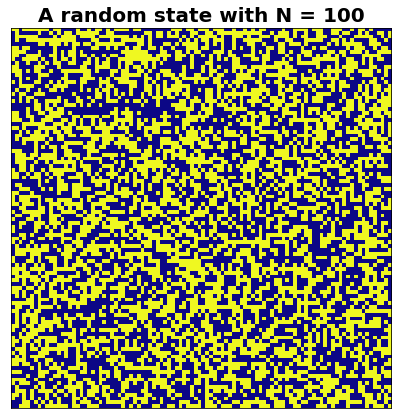

In [5]:
try_state = init_lattice(100)
fig, ax = plt.subplots(figsize=(9,7))
ax.matshow(try_state, cmap = plt.cm.plasma) 
ax.set_xticks([])
ax.set_yticks([])
plt.title('A random state with N = 100', fontsize = 20, fontweight = "bold" )
plt.show()

In [6]:
#Let's define some useful functions
@jit(nopython=True)
def energy(state):
    
    '''define the energy at a given configuration'''
    
    N = state.shape[0]
    energy = 0
  
    for i in range(N):
        for j in range(N):

      # get nearest neighbours states
            nn = state[(i-1)%N, j] + state[(i+1)%N, j] + state[i, (j-1)%N] + state[i, (j+1)%N]
            energy +=  -state[i,j] * nn
    return energy / 2
    
@jit(nopython=True)    
def magnetization(state):
    
    '''define the magnetization per site'''
    
    Magn = np.sum(state)    
    return Magn

@jit(nopython=True)
def delta(s,a,b):
    L= int(s.shape[0])
    
    '''define delta E between 2 spin configurations'''

    return 2*s[a,b]*(s[a,(b+1)%L]+s[a,(b-1)%L]+s[(a+1)%L,b]+s[(a-1)%L,b])   #consider only nearest neighbours


# **PHASE TRANSITION ANALYSIS**

In [7]:
# Define Monte Carlo function
@jit(nopython=True)
def mc_step(s,temp):
    
    L = int(s.shape[0])
    for i in prange(int(L*L)):
        
        # choose a random spin on the grid
        a, b = np.random.randint(0,L), np.random.randint(0,L)
        
        # compute the delta energy before and after the flip of s(a,b)
        delta_E = delta(s,a,b)  

        # metropolis test and spin-flip
        if delta_E <= 0 or np.random.uniform(0, 1) < np.exp(-delta_E/temp):
            s[a,b]*=-1
    return s

# ---Finite-size scaling---

For this try, I made sure that the temperatures are centered in T_c, and concentrated around T_c (51 points between T_c-0.5 and T_c+0.5).

In [12]:
@jit(nopython=True)
def Ising(L,T,eq_steps,steps):
    
    s = np.ones((L,L))
    '''Equilibration'''
    
    E_eq = np.zeros(eq_steps)
    M_eq = np.zeros(eq_steps)
    for i in range(eq_steps):
            #keep trace of energy and magnetisation
            E_eq[i] = energy(s)
            M_eq[i] = magnetization(s)
            #update the state
            s = mc_step(s,T)
            
            
    '''Simulation'''
    
    E = np.zeros(steps)
    M = np.zeros(steps)
    for i in range(steps):
          #keep trace of energy and magnetisation
            E[i] = energy(s)
            M[i] = magnetization(s)
            #update the state
            s = mc_step(s,T)
    
    E_mean = np.mean(E)
    M_mean = np.mean(M)
    C = (np.std(E)**2)/(T**2)
    Chi = (np.std(M)**2)/(T)

  ### Return results
    return (E_mean, M_mean, C, Chi) 


eq_steps = int(1e2)
steps = int(1e4)

T_c = 2/np.log(1 + np.sqrt(2))
L_val=[32,64,128,256,400,512]
nl = int(len(L_val)) 
nt = 50 
E_old,M_old,C_old,Chi_old = np.zeros((nl,nt+1)),np.zeros((nl,nt+1)),np.zeros((nl,nt+1)),np.zeros((nl,nt+1))
Te = np.linspace(T_c-0.5,T_c+0.5,nt+1)


for i,L in enumerate(L_val):
    print('Simulating N={}'.format(L))
    for j,T in enumerate(Te):
    #print('\t{}/{}  beta: {}'.format(j,N_T,beta))
        E_mean, M_mean, C_mean, Chi_mean = Ising( L, T, eq_steps=eq_steps, steps=steps)

        E_old[i,j] = E_mean
        M_old[i,j] = M_mean
        C_old[i,j] = C_mean
        Chi_old[i,j] = Chi_mean

Simulating N=32
Simulating N=64
Simulating N=128
Simulating N=256
Simulating N=400
Simulating N=512


In [ ]:
print(Chi_old)

In [14]:
def plot_values (E,M,C,Chi,L_val):
    titles = ['Energy','Magnetisation','Specific Heat','Susceptibility']
    #labels = ['e', 'm', 'c', 'chi']
    physical_quantities = [E,np.abs(M),C,Chi]
    plt.figure(figsize = (16,10))
    for i in range(len(physical_quantities)):
        ax = plt.subplot(2,2,i+1)
        ax.set_xlabel('Temperature', fontsize=18)
        ax.set_ylabel(titles[i], fontsize=18)
        ax.set_title(titles[i], fontsize = 20, fontweight = "bold" )
        ax.grid('--', alpha= 0.7)
        for j in range(nl):
            ax.plot(Te, physical_quantities[i][j] / L_val[j]**2, '.',markersize=9, label='N='+str(L_val[j]), alpha=0.7)
            
            ax.legend()
            
    plt.subplots_adjust(hspace=0.3)

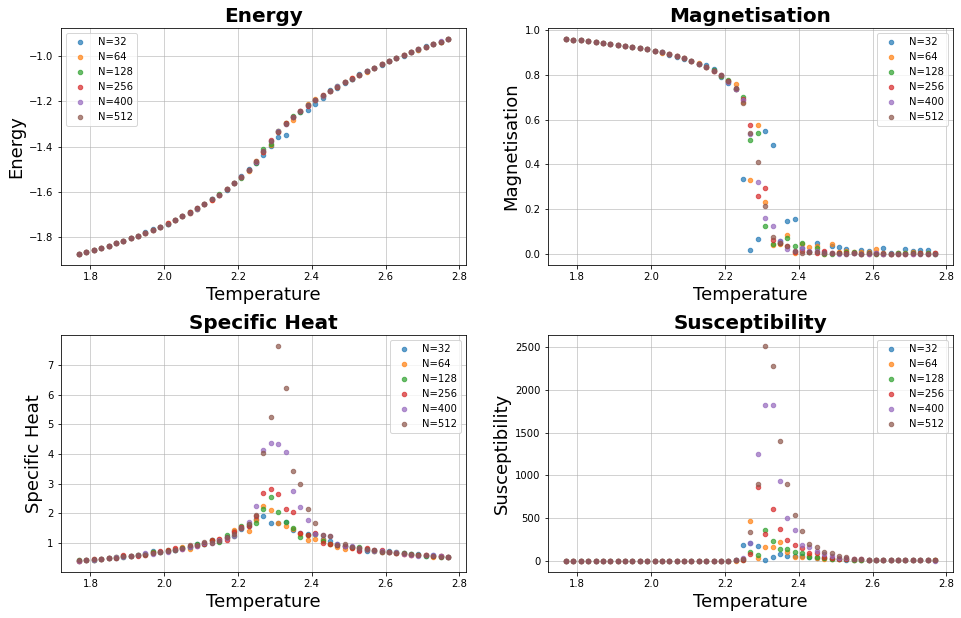

In [15]:
plot_values(E_old,M_old,C_old,Chi_old,L_val)

## 1st attempt

For this attempt I followed the following reasoning: for a given volume V, the critical temperature at that volume (I worked with $\beta_c=1/T_c$) is correlated to the critical temperature at infinite dimension as follows: $$ |\beta_c(\infty)-\beta_c(V)|^{-\nu} \propto L$$
It follows: $$(1) \quad \beta_c(V)=\beta_c(\infty)-cL^{-1/\nu}$$     
For the susceptibility, the relation is: $$(2) \quad \chi_{max}=cL^{\gamma/\nu}$$

For each dimension L, the critical temperature for that dimension can be estimated by looking at the maximum of Chi:
- Find the max of Chi for each L, and the associated maximum T;
- Find $\beta_c(V)=\beta_{max}(V)=1/T_{max}(V)$;
- Fit $\beta_max$ to to the function (1) with $\beta_c(\infty),c$ and $x=-1/\nu$ as the parameters;
- Find $\gamma$ by fitting Chi_max to the function (2), where $z=\gamma/\nu$ with $\nu$ found before.    

The values should be:
- $\beta_c\sim 0.44$ (so that $T_c \sim 2.26$);
- $\nu=1$;
- $\gamma=1.75$.


[ 0.42769422 -0.04204464  0.32691788]
2.3381190585485583 3.0588721496166618


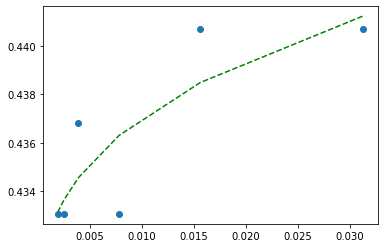

In [20]:
from scipy import optimize

T_c =2/np.log(1+np.sqrt(2))

Chi_max = np.zeros((nl,))
T_max = np.zeros((nl,))

for i in range(nl):
    imax = np.argmax(Chi_old[i,:])            
    Chi_max[i] = Chi_old[i,imax]
    T_max[i] = Te[imax]

beta_max = 1/T_max

def exp_fit(n,beta_c,c,x):
    beta_max = beta_c-c*n**x
    return beta_max

L_inv = np.array([1/L for L in L_val])
guess = [0.45,0.2,1]
par, cov = curve_fit(exp_fit,L_inv,beta_max,guess,maxfev=int(1e6)) 
print(par)
Tc_est = par[0]**(-1) 
nu = par[2]**(-1)
print(Tc_est, nu)

plt.plot(L_inv, beta_max, 'o')
plt.plot(L_inv, par[0]-par[1]*L_inv**(par[2]), 'g--')
    

10.30034229118005
3.3673660706842194


/tmp/ipykernel_28154/3168725718.py:4: RuntimeWarning: overflow encountered in power
  Chi_max = c*(L**z)


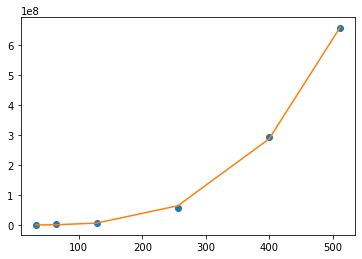

In [21]:
L_ar = np.array(L_val)   #turned into an array otherwise there were some errors

def chi_fit(L,c,z):
    Chi_max = c*(L**z)
    return Chi_max
 
guess=[int(1e2),1.7]
par_chi, cov_chi = curve_fit(chi_fit,L_ar,Chi_max,guess,maxfev=int(1e6))
z = par_chi[1]
gamma = z*nu                                                      
print(gamma)
print(z)
plt.plot(L_ar,Chi_max,'o')
plt.plot(L_ar,par_chi[0]*(L_ar**par_chi[1]))

As we can see, everything is bad. Except for the critical temperature which is kinda nice.

## 2nd attempt

This is a less detailed attempt, where I only try to estimate $\gamma$, not caring at all about the critical temperature, even if it's the only good thing in this notebook and the only reason I'm still alive.

In this attempt, I assume that $\nu=1$, and I only use the relation (2) from before to make a log-log fit of $\chi_{max}$ as a function of L.    
The fit turns out kind of good, but gamma is wrong. Since the fit is good, though, I think the problem is in our data, even if I don't even know what to do anymore.


[2.8386986 2.3501963]
2.8386985974217187


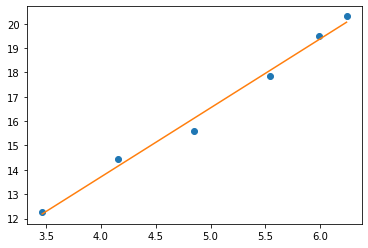

In [22]:
Chi_max = np.zeros((nl))
Tmax = np.zeros((nl))
for i in range(nl):   
    imax = np.argmax(Chi_old[i])
    Chi_max[i] = Chi_old[i,imax]
    Tmax[i] = Te[imax]

logchi = np.log(Chi_max)
logL = np.log(L_val)

def gamma_fit(logL,z,c):
    logchi = z*logL+c
    return logchi

guess = [1.7,2]

params, covs = optimize.curve_fit(gamma_fit,logL,logchi,guess, maxfev=int(1e6))
gamma = params[0]
print(params)
print(gamma)

plt.plot(logL,logchi,'o')
plt.plot(logL,gamma_fit(logL,params[0],params[1]))

Below are the Chis I obtained for a previous iteration for L=32,64,128,256

[[9.25948369e+01 1.14841807e+02 1.08610611e+02 1.35136627e+02
  1.42025454e+02 1.80359514e+02 1.90927872e+02 2.07831367e+02
  2.43685138e+02 2.66980973e+02 2.79543002e+02 3.51429645e+02
  4.48201329e+02 4.86907315e+02 6.23571752e+02 5.66840326e+02
  6.80455526e+02 9.59469291e+02 1.16978444e+03 2.92573428e+03
  2.26551039e+03 2.31769653e+03 2.55092505e+03 1.51683452e+05
  2.25678982e+05 2.10589931e+05 7.18264821e+04 1.61652977e+05
  8.59535682e+04 8.64664978e+04 7.08999700e+04 7.22611140e+04
  5.06906599e+04 4.73533646e+04 3.29305420e+04 2.30906798e+04
  3.48821609e+04 2.58997232e+04 1.92716358e+04 1.76097842e+04
  1.75326227e+04 1.51029939e+04 1.40363831e+04 1.25350055e+04
  1.04769483e+04 9.39546821e+03 9.19767730e+03 8.90247852e+03
  8.04848052e+03 7.61120130e+03 7.15532341e+03]
 [4.01980223e+02 4.32803337e+02 4.71348500e+02 5.72943665e+02
  6.44153409e+02 6.90697236e+02 7.65503467e+02 8.61151294e+02
  9.77551730e+02 1.01885751e+03 1.31213790e+03 1.71224891e+03
  1.60213610e+03 1.80786791e+03 2.40445344e+03 2.41064081e+03
  3.04769678e+03 1.44427017e+04 7.29213376e+03 6.00108725e+03
  1.03291541e+04 1.11077969e+04 2.41503561e+04 2.22471387e+04
  5.66557953e+04 1.47439807e+05 1.27436506e+05 6.55020924e+05
  7.93094452e+05 7.79278354e+05 3.39058063e+05 3.08143202e+05
  1.68498882e+05 2.21683010e+05 1.24825774e+05 1.49727011e+05
  9.60430255e+04 8.62757752e+04 8.27115178e+04 7.02406308e+04
  5.99345680e+04 5.80271418e+04 7.01181160e+04 4.69481245e+04
  5.09621226e+04 4.13312499e+04 3.58625260e+04 3.37947790e+04
  2.97522766e+04 3.10047743e+04 3.04506177e+04]
 [1.61276327e+03 1.69774959e+03 2.01056151e+03 2.29376099e+03
  2.40974575e+03 2.66538119e+03 2.98278410e+03 3.52454995e+03
  3.66445063e+03 4.30381724e+03 5.03035229e+03 6.53425639e+03
  6.41063132e+03 7.73149336e+03 9.25492439e+03 1.24535486e+04
  1.29431171e+04 1.67802082e+04 2.42072156e+04 3.40717703e+04
  4.42360074e+04 7.03976565e+04 8.95296556e+04 1.65777415e+05
  3.30528533e+05 1.00849741e+06 1.56079490e+06 7.21528525e+06
  7.52049980e+06 3.27258504e+06 3.11329107e+06 1.25097419e+06
  9.43475982e+05 8.17359336e+05 6.29842958e+05 5.43701718e+05
  4.79150327e+05 4.43664429e+05 3.37789335e+05 3.14230374e+05
  2.51666796e+05 3.01611511e+05 1.85805318e+05 1.88077022e+05
  1.67722670e+05 1.77979288e+05 1.43595776e+05 1.19346826e+05
  1.49673186e+05 1.31311614e+05 1.16666488e+05]
 [6.71508870e+03 6.93675980e+03 7.94529527e+03 8.63128075e+03
  9.32397306e+03 1.12720840e+04 1.28245003e+04 1.35182814e+04
  1.49240155e+04 1.82636133e+04 2.01021098e+04 2.30030349e+04
  2.70260084e+04 3.01137571e+04 3.46350445e+04 4.57856571e+04
  5.07178958e+04 7.05363429e+04 9.38960666e+04 1.13234062e+05
  2.20368671e+05 2.46708906e+05 3.37454688e+05 1.01365685e+06
  1.13604035e+06 4.59133607e+06 2.59393021e+07 2.14876983e+07
  1.84011295e+07 2.54883546e+07 2.12920993e+07 8.46622412e+06
  9.27674901e+06 5.45637964e+06 2.81579412e+06 3.58475168e+06
  2.59843930e+06 2.01602417e+06 1.56906658e+06 1.24410193e+06
  1.01611063e+06 1.01673734e+06 9.49123280e+05 8.21209090e+05
  7.25406368e+05 6.66692472e+05 5.67356864e+05 5.69184340e+05
  5.88775232e+05 5.13857938e+05 4.65189850e+05]]

Below are the Chis obtained for L=32,64,128,256,400,512

[[9.76062337e+01 1.05989636e+02 1.16391663e+02 1.29227750e+02
  1.52900438e+02 1.55826099e+02 1.97366904e+02 2.13091378e+02
  2.29827234e+02 2.96225484e+02 3.78626511e+02 3.32740673e+02
  3.89814755e+02 4.26657423e+02 6.64878328e+02 7.16790500e+02
  9.93566699e+02 9.46711799e+02 1.43639747e+03 1.14672591e+03
  1.90209373e+03 4.62872228e+03 4.75001450e+03 7.39950462e+03
  1.91137524e+05 2.13257375e+05 1.83165331e+05 1.78708389e+04
  4.88596534e+04 8.05224891e+04 6.18782083e+04 6.25681251e+04
  6.31360240e+04 5.01897190e+04 3.30165245e+04 3.21577269e+04
  2.40772841e+04 2.47499090e+04 1.76935274e+04 1.80554620e+04
  1.62196594e+04 1.28580481e+04 1.28502295e+04 1.20969034e+04
  1.29909491e+04 1.14455752e+04 1.00903644e+04 9.95614601e+03
  8.23644897e+03 8.19565913e+03 8.06372027e+03]
 [4.00073133e+02 4.36407323e+02 4.60947204e+02 5.39259216e+02
  5.78190498e+02 6.87283371e+02 8.02482621e+02 8.36703444e+02
  1.02601480e+03 1.04635296e+03 1.41891888e+03 1.44492587e+03
  1.83034997e+03 1.98035425e+03 2.28975352e+03 2.26794980e+03
  3.47227748e+03 4.25592250e+03 4.73817112e+03 9.35894720e+03
  7.83081512e+03 1.69191523e+04 2.11673516e+04 1.54390139e+04
  9.99647495e+04 1.90633309e+06 1.37013664e+05 6.61152907e+05
  6.55729394e+05 8.90200259e+05 4.46726261e+05 1.87012977e+05
  1.80134342e+05 2.69065145e+05 1.44410073e+05 1.20456151e+05
  1.16652496e+05 9.48847570e+04 8.70919175e+04 6.92471092e+04
  6.09690975e+04 6.23304326e+04 4.80645206e+04 5.75826697e+04
  4.59503500e+04 3.80879611e+04 3.97039376e+04 3.38320046e+04
  3.17579591e+04 3.01439179e+04 2.97209420e+04]
 [1.62413926e+03 1.74305481e+03 1.94910409e+03 2.19588146e+03
  2.54250983e+03 2.86159192e+03 3.00053013e+03 3.49270956e+03
  3.93281463e+03 4.81641901e+03 5.16107432e+03 5.57916096e+03
  6.91374506e+03 7.81620706e+03 1.06564647e+04 1.11248891e+04
  1.31882482e+04 1.82031218e+04 2.99711129e+04 2.64492804e+04
  3.91811862e+04 6.69084100e+04 8.13510830e+04 1.35440055e+05
  1.81676802e+05 1.66905928e+06 1.15965753e+06 5.95755256e+06
  3.80948293e+06 2.25909018e+06 2.39094754e+06 1.74615190e+06
  1.59564854e+06 6.99279608e+05 8.02783707e+05 6.38758690e+05
  4.43723258e+05 3.63733502e+05 3.48929396e+05 2.80530046e+05
  2.67538489e+05 2.38925529e+05 2.37206016e+05 1.88711104e+05
  1.85347558e+05 1.69889013e+05 1.36301844e+05 1.46540560e+05
  1.24136975e+05 1.19181205e+05 1.14820276e+05]
 [6.40392405e+03 7.20227251e+03 7.90905406e+03 8.37126490e+03
  9.31183128e+03 1.05756624e+04 1.33316506e+04 1.34324119e+04
  1.46388164e+04 1.67847224e+04 1.99461953e+04 2.35841621e+04
  2.68838219e+04 3.43792454e+04 3.76284754e+04 4.70967751e+04
  5.16918951e+04 6.48568145e+04 8.79737380e+04 1.20063124e+05
  1.34964131e+05 2.47297324e+05 4.28619274e+05 6.37766025e+05
  1.18514258e+06 5.73583601e+06 5.64708122e+07 2.03808303e+07
  3.94956090e+07 2.46262525e+07 1.61758750e+07 1.20079879e+07
  1.00048870e+07 6.22720449e+06 6.10144585e+06 3.20847473e+06
  2.37253964e+06 1.72768381e+06 1.85177861e+06 1.76817156e+06
  1.30456421e+06 9.58753775e+05 1.13150570e+06 7.63664075e+05
  7.36788383e+05 6.59441781e+05 6.11561541e+05 6.41625799e+05
  5.39334699e+05 4.85798688e+05 5.01843877e+05]
 [1.51754082e+04 1.69364417e+04 1.91698129e+04 2.08669653e+04
  2.43160739e+04 2.63727725e+04 2.98403992e+04 3.31616120e+04
  3.87247080e+04 4.39226931e+04 4.58881586e+04 5.70233126e+04
  6.09767874e+04 7.64222336e+04 9.08163656e+04 1.08039307e+05
  1.24130334e+05 1.65537974e+05 1.96793078e+05 3.08112665e+05
  3.62052317e+05 4.50593083e+05 1.05495333e+06 1.36951370e+06
  5.00817898e+06 3.38749001e+07 2.00591932e+08 2.91742759e+08
  2.91355781e+08 1.49146856e+08 8.00521457e+07 5.89080125e+07
  2.94862153e+07 2.58576677e+07 1.91096043e+07 1.31312159e+07
  9.58500676e+06 6.12967208e+06 5.35575485e+06 4.34350575e+06
  3.02357459e+06 2.67091758e+06 2.25651657e+06 1.95942651e+06
  1.74419908e+06 1.71256066e+06 1.49323377e+06 1.30473089e+06
  1.32277470e+06 1.40473684e+06 1.02848240e+06]
 [2.70320212e+04 2.74864960e+04 3.14092450e+04 3.41336300e+04
  3.88262992e+04 4.21108560e+04 5.02200715e+04 5.49712934e+04
  6.33334381e+04 6.86813866e+04 8.07338268e+04 9.19158927e+04
  1.11430885e+05 1.23838561e+05 1.55537337e+05 2.00376618e+05
  2.24199172e+05 2.94225207e+05 3.25401557e+05 3.87582513e+05
  6.26836444e+05 9.20509510e+05 1.57313964e+06 2.21671491e+06
  7.08892966e+06 8.93386577e+07 2.36444851e+08 6.57965029e+08
  5.98842724e+08 3.67390456e+08 2.35325457e+08 1.40041498e+08
  9.27510397e+07 5.36058964e+07 4.25319968e+07 2.74111352e+07
  2.38119517e+07 1.56189037e+07 1.14088805e+07 7.36515508e+06
  6.42892728e+06 4.77412348e+06 3.78423488e+06 3.41566118e+06
  2.91541232e+06 2.84863047e+06 2.62791287e+06 2.36456560e+06
  2.29259106e+06 1.88835503e+06 1.77167431e+06]]